***

This notebook contains the code samples found in Chapter 5, Section 1 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

We're about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. But first, let's take a practical look at a simple convnet example. It uses a convnet to classify MNIST digits, a task we performed in chapter 2 using a densely connected network (our test accuracy then was 97.8%). Even though the convnet will be basic, its accuracy will blow out of the water that of the densely connected model from chapter 2.

First let's take a look at the underlying data.

In [1]:
install.packages("keras")
library(keras)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




## load and inspect image data

In [2]:
mnist <- dataset_mnist()

class(mnist)
names(mnist)

class(mnist$train)
names(mnist$train)

class(mnist$train$x)
dim(mnist$train$x)
class(mnist$train$y)
dim(mnist$train$y)

print(mnist$train$y[1:10])

[1] "list"

[1] "train" "test"

[1] "list"

[1] "x" "y"

[1] "array"

[1] 60000    28    28

[1] "array"

[1] 60000

 [1] 5 0 4 1 9 2 1 3 1 4


In [3]:
# organize data

c(c(train_images, train_labels), c(test_images, test_labels)) %<-% mnist

train_images <- array_reshape(train_images, c(60000, 28, 28, 1))
train_images <- train_images / 255

test_images <- array_reshape(test_images, c(10000, 28, 28, 1))
test_images <- test_images / 255

train_labels <- to_categorical(train_labels)
test_labels <- to_categorical(test_labels)

      [,1] [,2] [,3] [,4] [,5] [,6]      [,7]       [,8]      [,9]      [,10]
 [1,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [2,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [3,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [4,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [5,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [6,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [7,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [8,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
 [9,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
[10,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.00000000
[11,]    0    0    0    0    0    0 0.0000000 0.00000000 0.0000000 0.18823529
[12,]    0    0    0    0    0    0 0.0000000 0.00000000 0.14901

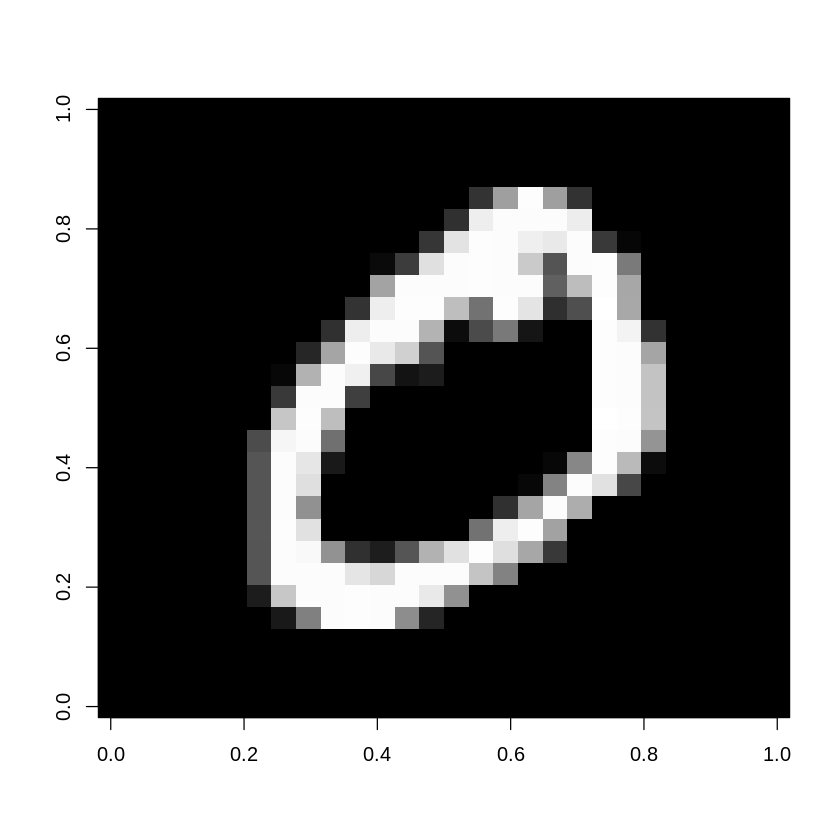

In [4]:
# underlying data is array of greyscale

print(train_images[2, , , ])

# see https://stackoverflow.com/questions/31882079/r-image-plots-matrix-rotated
# for logic of this plot

plot_t <- function(photo_array, raster = FALSE) {
  temp <- apply(photo_array, 2, rev)
  image(t(temp), col = grey(seq(0, 1, length = 256)), useRaster = raster)
}

plot_t(train_images[2, , , ])

The following lines of code show you what a basic convnet looks like.  It's a stack of `layer_conv_2d()` and `layer_max_pooling_2d()` layers. You'll see in a minute exactly what they do.

Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). In this case, we'll configure the convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this by passing the argument `input_shape = c(28, 28, 1)` to the first layer.


## build and fit CNN for predicting image class

In [5]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(28, 28, 1)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu")

Let's display the architecture of our convnet so far:

In [6]:
summary(model)

# number of parameters from first convolutional layer is 32 (filters) * 9 (params per filter) + 32 (biases)
# number of parameters from second convolutional layer is 64 (filters) * 9 (params per filter) * 32 (channels) + 64 (biases)
# number of parameters from third convolutional layer is 64 (filters) * 9 (params per filter) * 64 (channel) + 64 (biases)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_2 (Conv2D)                  (None, 26, 26, 32)              320         
 max_pooling2d_1 (MaxPooling2D)     (None, 13, 13, 32)              0           
 conv2d_1 (Conv2D)                  (None, 11, 11, 64)              18496       
 max_pooling2d (MaxPooling2D)       (None, 5, 5, 64)                0           
 conv2d (Conv2D)                    (None, 3, 3, 64)                36928       
Total params: 55744 (217.75 KB)
Trainable params: 55744 (217.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


You can see that the output of every `layer_conv_2d()` and `layer_max_pooling_2d()` is a 3D tensor of shape `(height, width, channels)`. The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first argument passed to the `layer_conv_2d()` (32 or 64).

The next step is to feed the last output tensor (of shape `(3, 3, 64)`) into a densely connected classifier network like those you're already familiar with: a stack of dense layers. These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few dense layers on top.

In [7]:
model <- model %>%
  layer_flatten() %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 10, activation = "softmax")

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [8]:
summary(model)

# number of parameters from first dense layer is 64 (neurons) * 576 (3*3*64 = flattened vector) + 64 (biases)
# number of parameters from second dense layer is 10 (classes) * 64 (input vector) + 10 (biases)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_2 (Conv2D)                  (None, 26, 26, 32)              320         
 max_pooling2d_1 (MaxPooling2D)     (None, 13, 13, 32)              0           
 conv2d_1 (Conv2D)                  (None, 11, 11, 64)              18496       
 max_pooling2d (MaxPooling2D)       (None, 5, 5, 64)                0           
 conv2d (Conv2D)                    (None, 3, 3, 64)                36928       
 flatten (Flatten)                  (None, 576)                     0           
 dense_1 (Dense)                    (None, 64)                      36928       
 dense (Dense)                      (None, 10)                      650         
Total params: 93322 (364.54 KB)
Trainable params: 93322 (364.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________

As you can see, the `(3, 3, 64)` outputs are flattened into vectors of shape `(576)` before going through two dense layers.

Now, let's train the convnet on the MNIST digits. We'll reuse a lot of the code from the MNIST example in chapter 2.

In [9]:
## takes a few minutes, so skip to load model

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

model %>% fit(
  train_images, train_labels,
  epochs = 5, batch_size = 64
)

save_model_hdf5(model, "./mnist.hdf5")

## explore fitted model

In [10]:
model_fit <- load_model_hdf5("./05_mnist.hdf5")

Let's evaluate the model on the test data:

In [11]:
results <- model_fit %>% evaluate(test_images, test_labels)

In [12]:
results

loss   accuracy 
0.02483638 0.99280000

We can also explore the model parameters a bit.  This is adapted from https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/.

[1] "conv2d_2"

-0.008152056,-0.09509458,-0.27095395
-0.007999404,0.13218246,0.11522303
0.031938475,0.06608814,0.08901446


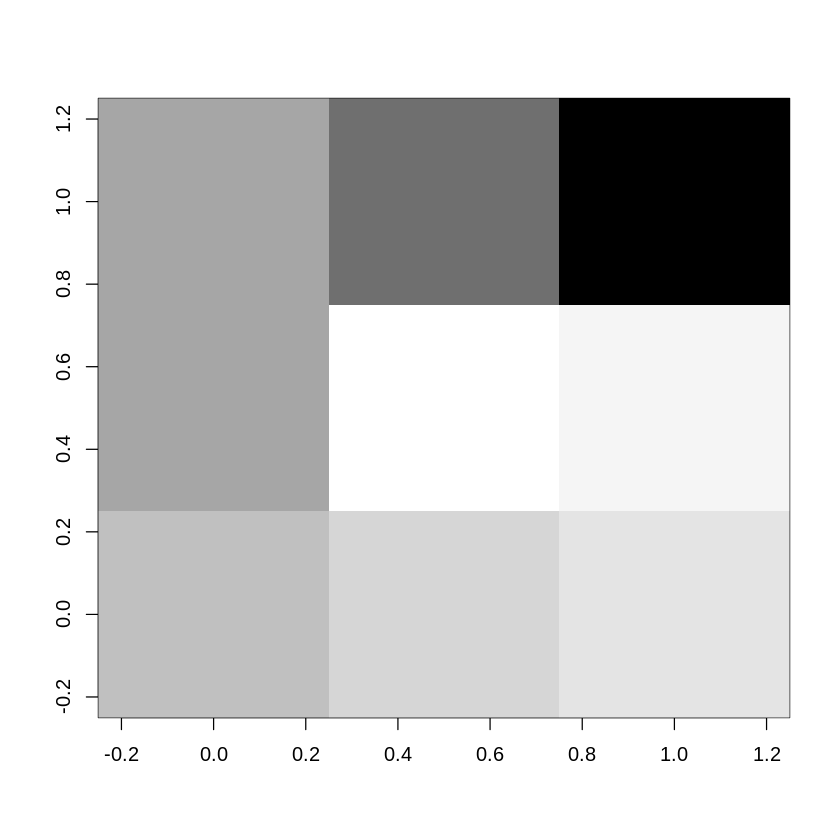

In [30]:
# explore estimated filter M from first layer of CNN
M <- 10

model_fit$layers[[1]]$name # name of first layer of network
model_fit$layers[[1]]$get_weights()[[1]][, , , M] # estimated parameters for

# plot of different convolutional filters

min_f <- min(model_fit$layers[[1]]$get_weights()[[1]][, , , ])
max_f <- max(model_fit$layers[[1]]$get_weights()[[1]][, , , ])

# normalized version of second filter
temp_f <- (model_fit$layers[[1]]$get_weights()[[1]][, , , M] - min_f) /
  (max_f - min_f)

plot_t(temp_f)

Finally, we can associate images with these convolutional filters.

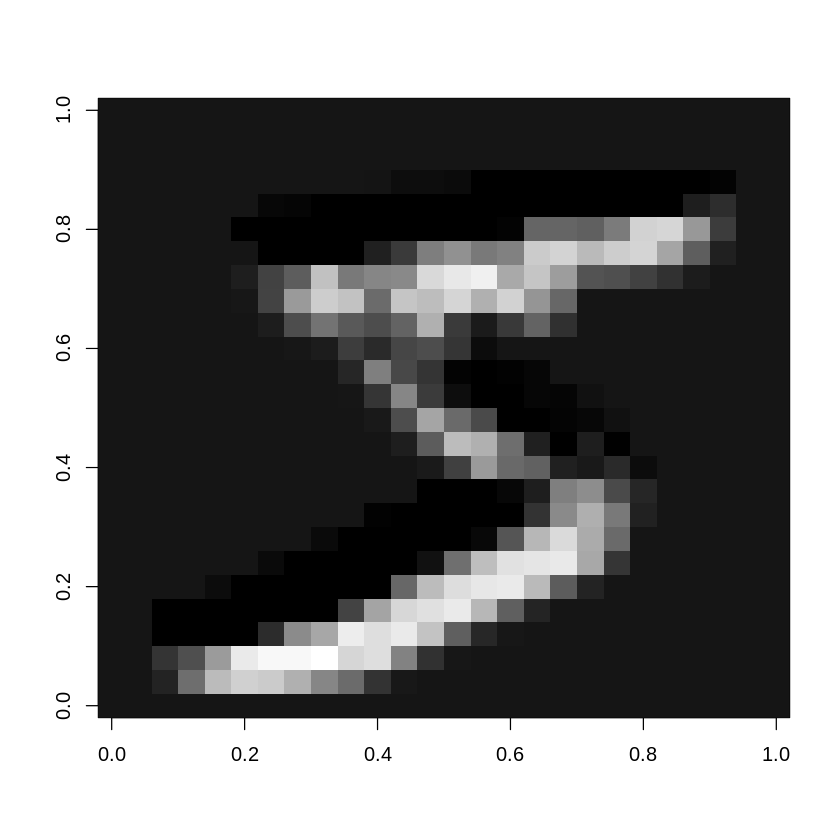

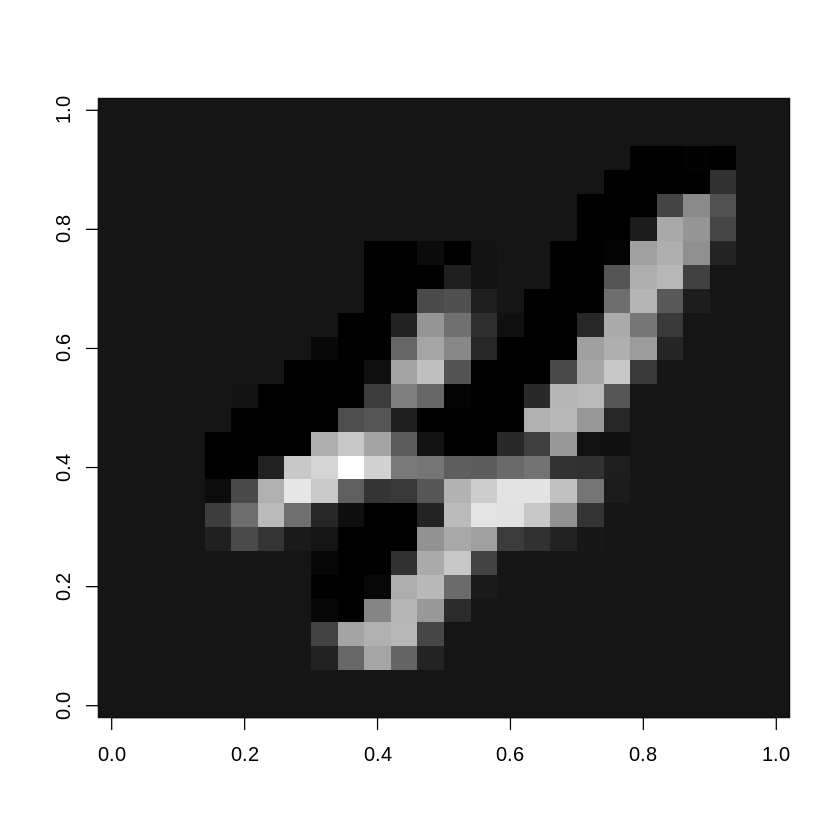

In [31]:
model1 <- keras_model(inputs = model$inputs, outputs = model$layers[[1]]$output)

# careful about running out of memory
temp2 <- predict(model1, train_images[1:10, , , ])

# plot association of first training image with second filter
plot_t(temp2[1, , , M])

# plot association of tenth training image with second filter
plot_t(temp2[10, , , M])